# Regressorion with Orbit

In this demo, we want to demonstartate how to use the different arguments in the model classes (LGT or DLT) to realize different setups for the regressors. Those could be very useful in practice when tuning the models.

In [1]:
import pandas as pd
import numpy as np

# from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from orbit.dlt import DLT
from orbit.lgt import LGT

from orbit.utils.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative_regression

In [2]:
print(np.__version__)

1.18.2


## Simulation of Regression with Trend

In [3]:
# To scale regressor values in a nicer way
REG_BASE = 1000
NUM_OF_REGRESSORS = 10
SEED = 2020

In [4]:
raw_df, coefs, trend, seas = make_ts_multiplicative_regression(
    series_len=200, seasonality=52, num_of_regressors=NUM_OF_REGRESSORS, coef_mean=.1, coef_sd=.1,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=2.0,
    regression_prob=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.1, response_col='response', seed=SEED
)

In [5]:
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,regressor_10,date
0,3189.0,0.0,1842.0,2548.0,1047.0,0.0,1755.0,1858.0,1871.0,912.0,0.0,2016-01-04
1,3709.0,1429.0,2055.0,1936.0,1974.0,1765.0,0.0,1272.0,1469.0,0.0,3932.0,2016-02-25
2,2935.0,2447.0,0.0,819.0,1753.0,2383.0,0.0,0.0,1685.0,1146.0,0.0,2016-04-17
3,896.0,1315.0,1771.0,0.0,0.0,0.0,0.0,0.0,0.0,1612.0,0.0,2016-06-08
4,2634.0,0.0,1352.0,2183.0,1198.0,1432.0,1030.0,1262.0,1887.0,0.0,2649.0,2016-07-30


In [6]:
print(coefs)

[ 0.22602066  0.12231785  0.23325487 -0.04182046  0.0727203   0.1066778
  0.12510171  0.12726848 -0.07605049  0.20879701]


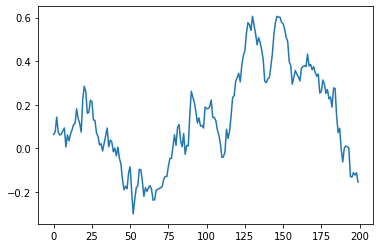

In [7]:
plt.plot(trend)

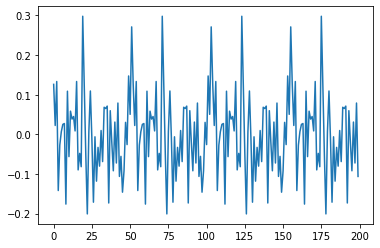

In [8]:
plt.plot(seas)

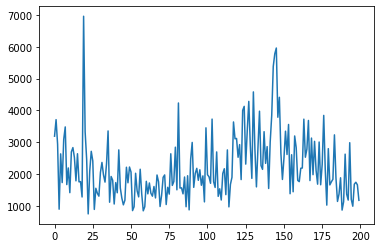

In [9]:
plt.plot(raw_df['response'])

## Estimating Coefficients I - full relevance

Assume we observe the data frame `df` and the scaler `REG_BASE`

In [10]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [11]:
mod_lasso = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ca0c67519bd35a633062bf2038529c4 NOW.


In [12]:
mod_auto_ridge = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_auto_ridge.fit(df=df)

In [13]:
mod_fixed_ridge1 = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

In [14]:
mod_fixed_ridge2 = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.1] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

In [15]:
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

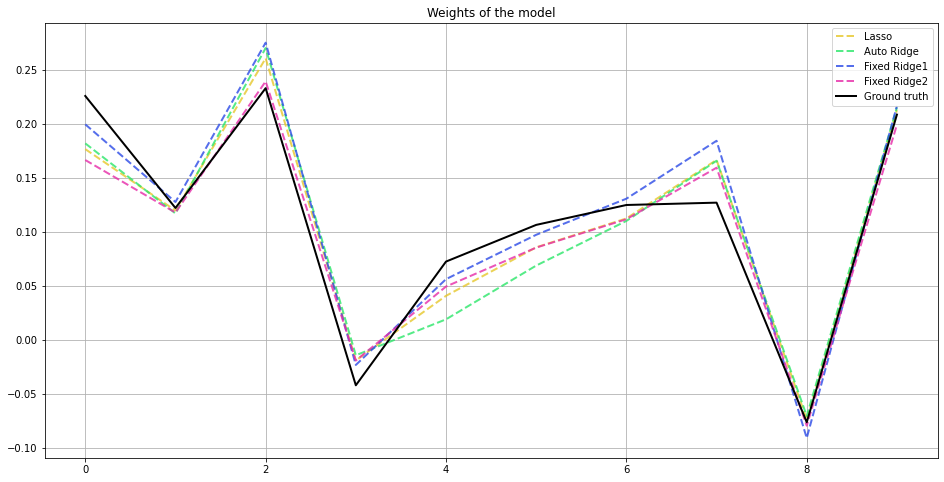

In [16]:
lw=2
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=0.8, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.8, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

## Checking Model Convergence and Posterior Distribution

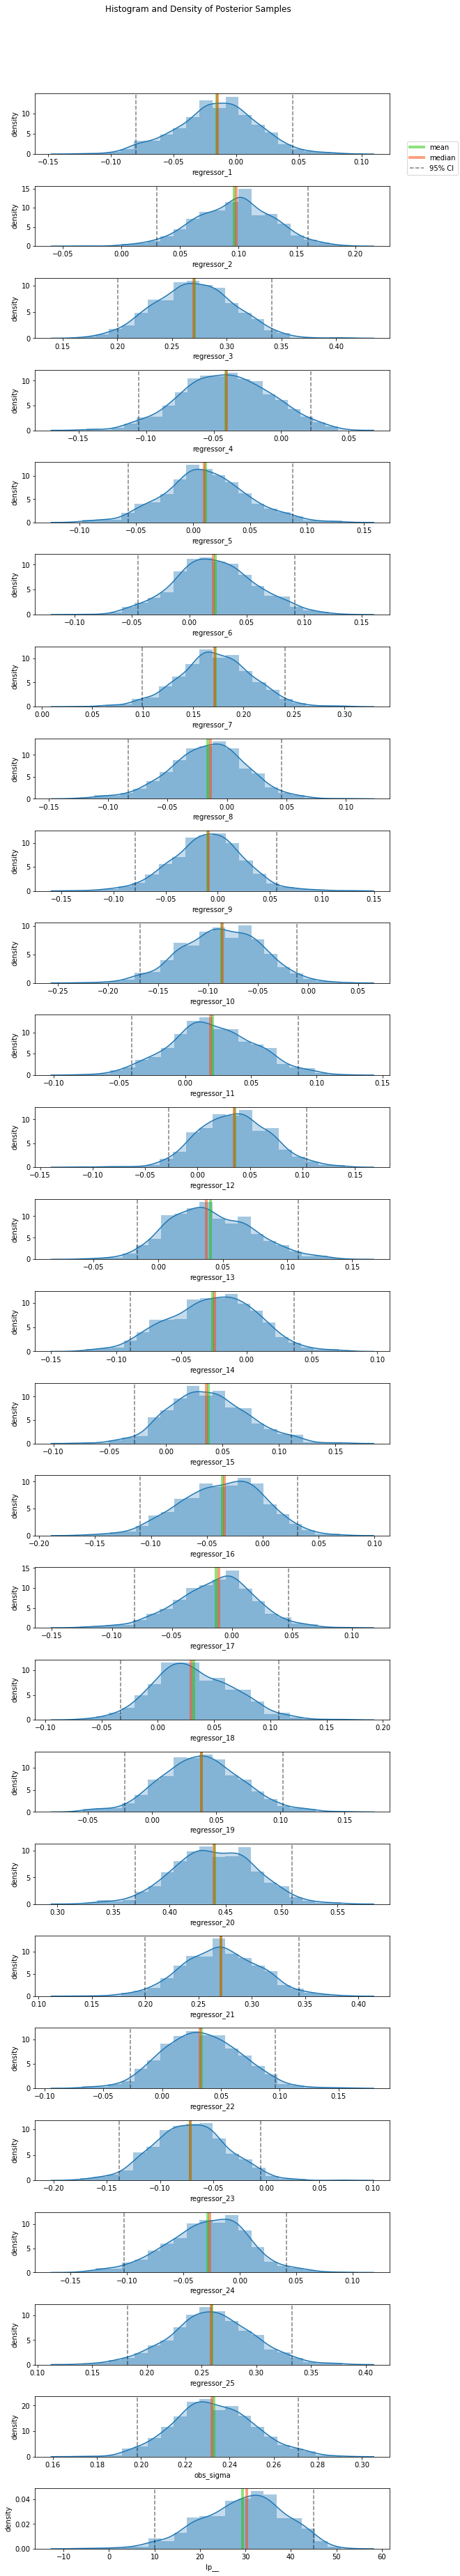

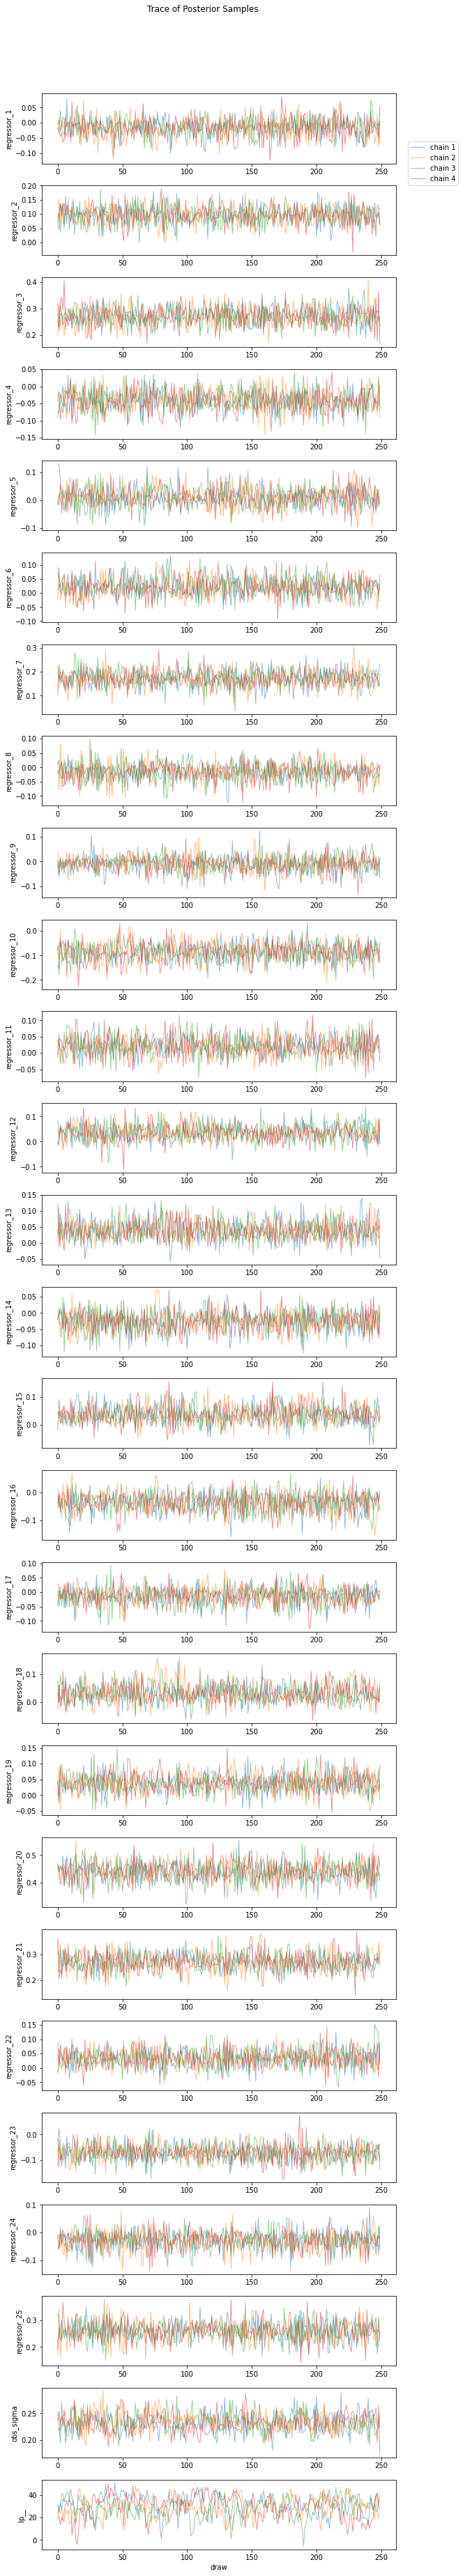

In [27]:
_ = mod_lasso.predict(df)
_ = plot_posterior_params(mod_lasso, kind='density')
_ = plot_posterior_params(mod_lasso, kind='trace')

## Estimating Coefficients II - high sparsity

In [17]:
NUM_OF_REGRESSORS = 25
REGRESSOR_SPARSITY = 0.8

In [18]:
raw_df, coefs, trend, seas = make_ts_multiplicative_regression(
    series_len=200, seasonality=52, num_of_regressors=NUM_OF_REGRESSORS, regressor_sparsity=REGRESSOR_SPARSITY,
    coef_mean=.1, coef_sd=.1,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=2.0,
    regression_prob=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.1, response_col='response', seed=SEED
)
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,...,regressor_17,regressor_18,regressor_19,regressor_20,regressor_21,regressor_22,regressor_23,regressor_24,regressor_25,date
0,10330.0,0.0,1842.0,2548.0,1047.0,0.0,1755.0,1858.0,1871.0,912.0,...,1272.0,1469.0,0.0,3932.0,2447.0,0.0,819.0,1753.0,2383.0,2016-01-04
1,3287.0,0.0,0.0,1685.0,1146.0,0.0,1315.0,1771.0,0.0,0.0,...,1352.0,2183.0,1198.0,1432.0,1030.0,1262.0,1887.0,0.0,2649.0,2016-02-25
2,5179.0,0.0,0.0,791.0,0.0,0.0,1805.0,0.0,1685.0,1179.0,...,0.0,2223.0,1749.0,1745.0,1751.0,0.0,2092.0,0.0,1701.0,2016-04-17
3,1735.0,2278.0,0.0,1707.0,0.0,2369.0,1234.0,0.0,1842.0,0.0,...,1419.0,0.0,1273.0,0.0,0.0,1334.0,0.0,1579.0,2985.0,2016-06-08
4,1804.0,1630.0,0.0,0.0,0.0,973.0,0.0,0.0,1295.0,1452.0,...,2595.0,2804.0,0.0,0.0,1906.0,1930.0,1312.0,0.0,2237.0,2016-07-30


In [19]:
print(coefs)

[ 0.          0.12231785  0.23325487 -0.04182046  0.          0.
  0.12510171  0.          0.          0.          0.          0.
  0.13847838  0.          0.10854218  0.          0.0102329   0.
  0.          0.39790427  0.21872741  0.04865511 -0.10082483  0.
  0.20933526]


In [20]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [21]:
mod_lasso = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

In [22]:
mod_auto_ridge = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_auto_ridge.fit(df=df)

In [23]:
mod_fixed_ridge1 = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

In [24]:
mod_fixed_ridge2 = LGT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.1] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

In [25]:
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

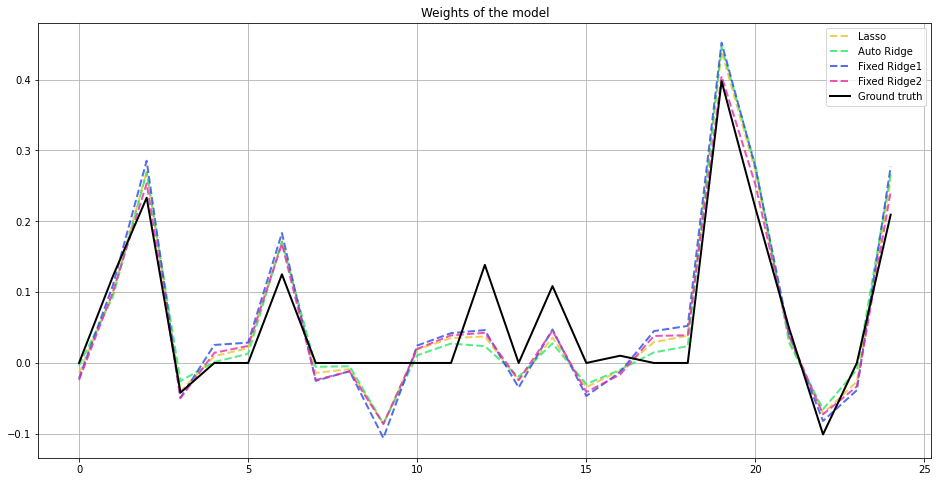

In [26]:
lw=2
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=0.8, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.8, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

# Appendix

## Simulate Regressions

In [28]:
SERIES_LEN = 200
CYCLE_LEN = 52
COEFS_MU, COEFS_SIGMA = 0.08, 0.03
NUM_COEFS = 5
SEED = 2020
SPARSITY = 0.2

In [29]:
RELEVANT_FEATURES = int(NUM_COEFS * SPARSITY)
RELEVANT_FEATURES_IDX = np.random.choice(NUM_COEFS, RELEVANT_FEATURES)
RELEVANT_FEATURES_IDX

array([3])

In [30]:
COEFS = np.random.default_rng(SEED).normal(COEFS_MU, COEFS_MU, NUM_COEFS)
COEFS[RELEVANT_FEATURES_IDX] = 0.0
COEFS

array([0.18081653, 0.09785428, 0.1866039 , 0.        , 0.05817624])

In [31]:
NOISE_TO_SIGNAL_RATIO = 0.5

In [32]:
# probabily of a signal appear
OBS_REG_PROB = 0.5
# scale and location parms of regressor values in log-scale
OBS_REG_LOG_LOC = 0.0
OBS_REG_LOG_SCALE = 0.2
# noise scale in log-scale
OBS_LOG_SCALE = NOISE_TO_SIGNAL_RATIO * OBS_REG_LOG_SCALE
# observation scale adjustment
OBS_BASE = 1000
REG_BASE = 1000

In [33]:
X_LOG1P = np.random.default_rng(SEED).normal(OBS_REG_LOG_LOC, OBS_REG_LOG_SCALE, SERIES_LEN * NUM_COEFS).reshape(SERIES_LEN, -1) + 1
Z = np.random.default_rng(SEED).binomial(1, OBS_REG_PROB, SERIES_LEN * NUM_COEFS).reshape(SERIES_LEN, -1)
X_OBS = X_LOG1P * Z
NOISE =  np.random.default_rng(SEED).normal(0, OBS_LOG_SCALE, SERIES_LEN)

In [34]:
print(X_LOG1P.shape, X_OBS.shape, COEFS.shape, NOISE.shape) 

(200, 5) (200, 5) (5,) (200,)


## Simulate Trend

### Random Walk

(200,)


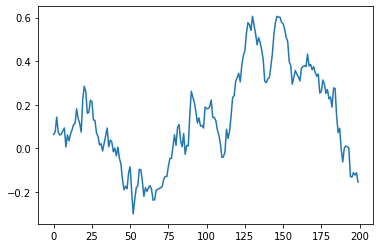

In [35]:
RW = np.random.default_rng(SEED).normal(0.001, 0.05, SERIES_LEN)
RW_LEVS = np.cumsum(RW)
print(RW_LEVS.shape)
plt.plot(RW_LEVS)

## Simulate Seasonality

(200,)


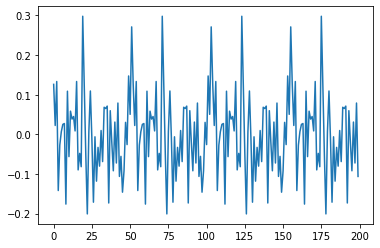

In [36]:
INIT_SEAS = np.zeros(CYCLE_LEN)
INIT_SEAS[:-1] = np.random.default_rng(SEED).normal(0, 0.1, CYCLE_LEN - 1)
INIT_SEAS[CYCLE_LEN - 1] = -1 * np.sum(INIT_SEAS)
SEAS = np.zeros(SERIES_LEN)
for idx in range(SERIES_LEN):
    SEAS[idx] = INIT_SEAS[idx % CYCLE_LEN]
print(SEAS.shape)
plt.plot(SEAS)

In [37]:
Y = np.round(OBS_BASE * np.exp(RW_LEVS + np.matmul(X_OBS, COEFS) + SEAS + NOISE))

In [38]:
X = np.round(np.expm1(X_LOG1P) * REG_BASE) 

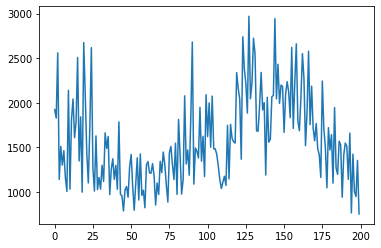

In [39]:
plt.plot(Y)

## Data Setup

Package response and signals into data frame

In [40]:
Y = Y.reshape(-1, 1)
print(Y.shape)

(200, 1)


In [41]:
# datetime index
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq='7D')
response_col = "response"
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_COEFS + 1)]
raw_df = pd.DataFrame(np.concatenate([Y, X], axis=1), columns = [response_col] + regressor_cols)
raw_df['week'] = dt 
raw_df.head(3)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,week
0,1924.0,2497.0,1842.0,2548.0,1047.0,1574.0,2016-01-04
1,1829.0,1755.0,1858.0,1871.0,912.0,2379.0,2016-01-11
2,2560.0,1429.0,2055.0,1936.0,1974.0,1765.0,2016-01-18
